## DO NOT TOUCH THIS MASTER VERSION OF THE NOTEBOOK. Create a duplicate notebook with your own copy name (e.g. marcelo_segmentador.ipynb) for your own usage


# Analyzing Segmentador data
Gabriel Emilio Herrera Oropeza <br>
13/06/2022

## *INSTRUCTIONS TO DEVELOPERS*

**Make sure to fetch and pull the most updated code and run `pip install .` before using the jupyter notebooks. Codes are constantly being improved and the workflow below work best with the newest version.**

This document describes the workflow to analyze data from segmented images that were previously processed by `insert tool name`. We will show how to import, visualise, filter and cluster the data using robust, simple-to-use functions. Many of these functions take up positional arguments that can be modified. To display the usage of these functions, run `help(name_of_function)`.

We begin by importing the `tool name` module.

In [1]:
from ngtools.analyzer import Analyzor

## Create Analyzor object class

We provide an Analyzor object class that facilitates storage of nuclei segmented data and its downstream processing. To construct this object, we can easily pass the path to Segmentador output directory to `Analyzor` class function:

In [52]:
path_to_experiments = "/Users/m./Dropbox (CDN Team)/Tiff Images/Images from Ruth"
obj = Analyzor(path_to_experiments, pattern="output*.csv", collated_csv=None)

## Data preprocessing

### Normalize DAPI intensity

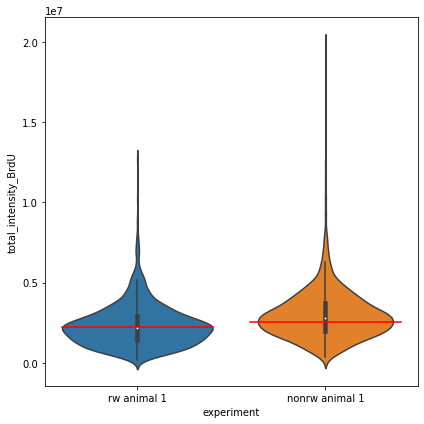

In [53]:
obj.normChannel(channel = "BrdU", method = "mode", nbins = 40, intensity_type = "total")

### Select single cells
Identify single cells based on DNA marker content. (Here we have to give the option to select the range of the spread we want to have from sum of DAPI intensity. You can see blebb and no Blebb have different spreading.

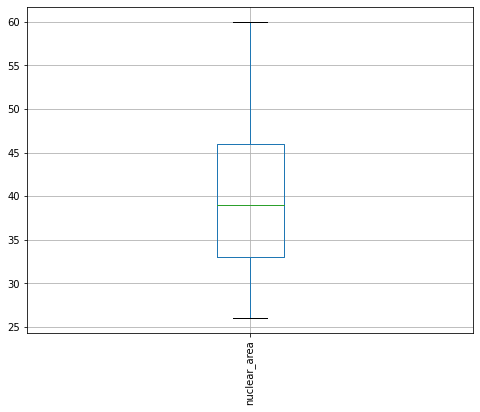

In [56]:
obj.plotVarDist(["nuclear_area"])

In [55]:
obj.filterCells(filter = "nuclear_area > 25", inplace = True)
obj.filterCells(filter = "nuclear_area <= 60", inplace = True)

In [58]:
%matplotlib tk
selected_cells = obj.chooseCells(x = "nuclear_area", y = "avg_intensity_BrdU")

In [62]:
%matplotlib inline

In [60]:
obj.filterCells(cells = selected_cells, inplace = True)

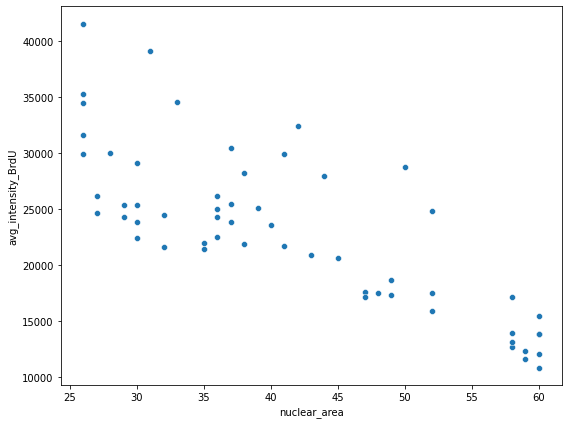

In [63]:
obj.plotData(x = "nuclear_area", y = "avg_intensity_BrdU")

In [7]:
obj.findSingleCells(byExperiment = True, nbins = 40, spread = 0.4, channel = None)

Using BrdU channel for qualifying single cells


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 155.23it/s]


In [5]:
# Keep only single cells
obj.filterCells(filter = "isSingleCell == True", inplace = True)

### Normalize channel intensities

In [8]:
obj.showADataVars()

['avg_intensity_BrdU', 'nuclear_area', 'nuclear_perimeter', 'major_axis', 'minor_axis', 'axes_ratio', 'circularity', 'eccentricity', 'solidity', 'avg_intensity_core_BrdU', 'avg_intensity_internal_ring_BrdU', 'avg_intensity_external_ring_BrdU', 'total_intensity_core_BrdU', 'total_intensity_internal_ring_BrdU', 'total_intensity_external_ring_BrdU', 'total_intensity_BrdU', 'avg_intensity_Gfap', 'total_intensity_Gfap', 'avg_intensity_Sox2', 'total_intensity_Sox2', 'avg_intensity_Mcm2', 'total_intensity_Mcm2', 'Gfap_x_Sox2', 'Gfap_x_Mcm2', 'Sox2_x_Mcm2', 'Gfap_x_Sox2_x_Mcm2', 'dna_peaks', 'dna_dots', 'dna_dots_size_median', 'spatial_entropy']


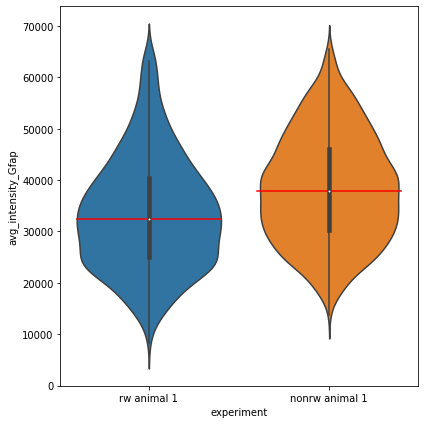

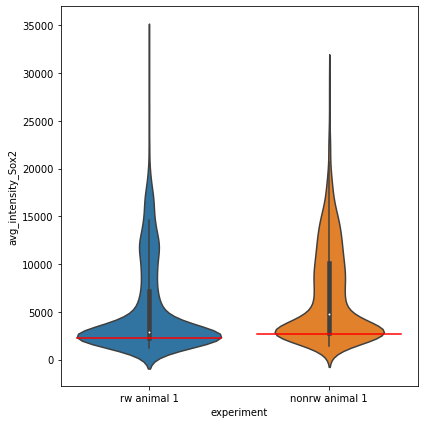

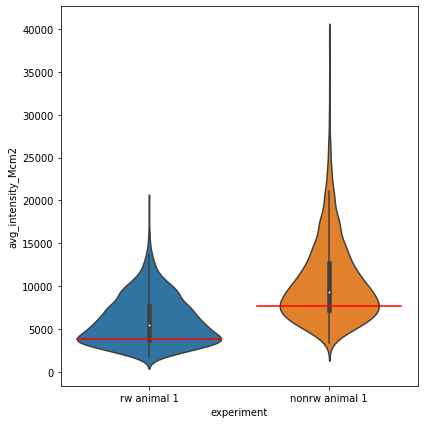

In [19]:
obj.normChannel(channel = "Gfap", method = "median", nbins = 50, intensity_type = "avg")
obj.normChannel(channel = "Sox2", method = "mode", nbins = 100, intensity_type = "avg")
obj.normChannel(channel = "Mcm2", method = "mode", nbins = 20, intensity_type = "avg")

### Filter cells

In [70]:
obj.count(["Sox2_group","Mcm2_group"], sort = False)

Sox2_group  Mcm2_group
1           1             10
2           2             10
1           2              7
0           2              6
3           2              6
2           1              5
            3              5
0           1              2
1           0              2
3           1              2
1           3              1
3           3              1
dtype: int64

In [65]:
help(obj.count)

Help on method count in module ngtools.analyzer:

count(vars) method of ngtools.analyzer.Analyzor instance
    Counts the number of observations for a (group of) variables.
    
    Parameters
    ----------
    vars : string or list of strings
        Name of features to summarise. Name should be found in dataframe.
    
    Returns
    -------
    None.



In [22]:
%matplotlib tk
chosen_cells = obj.chooseCells(x = "Sox2_group", y = "Mcm2_group")

In [23]:
%matplotlib inline


Showing 10 cells of a total of 57 in the selected data


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 62.62it/s]


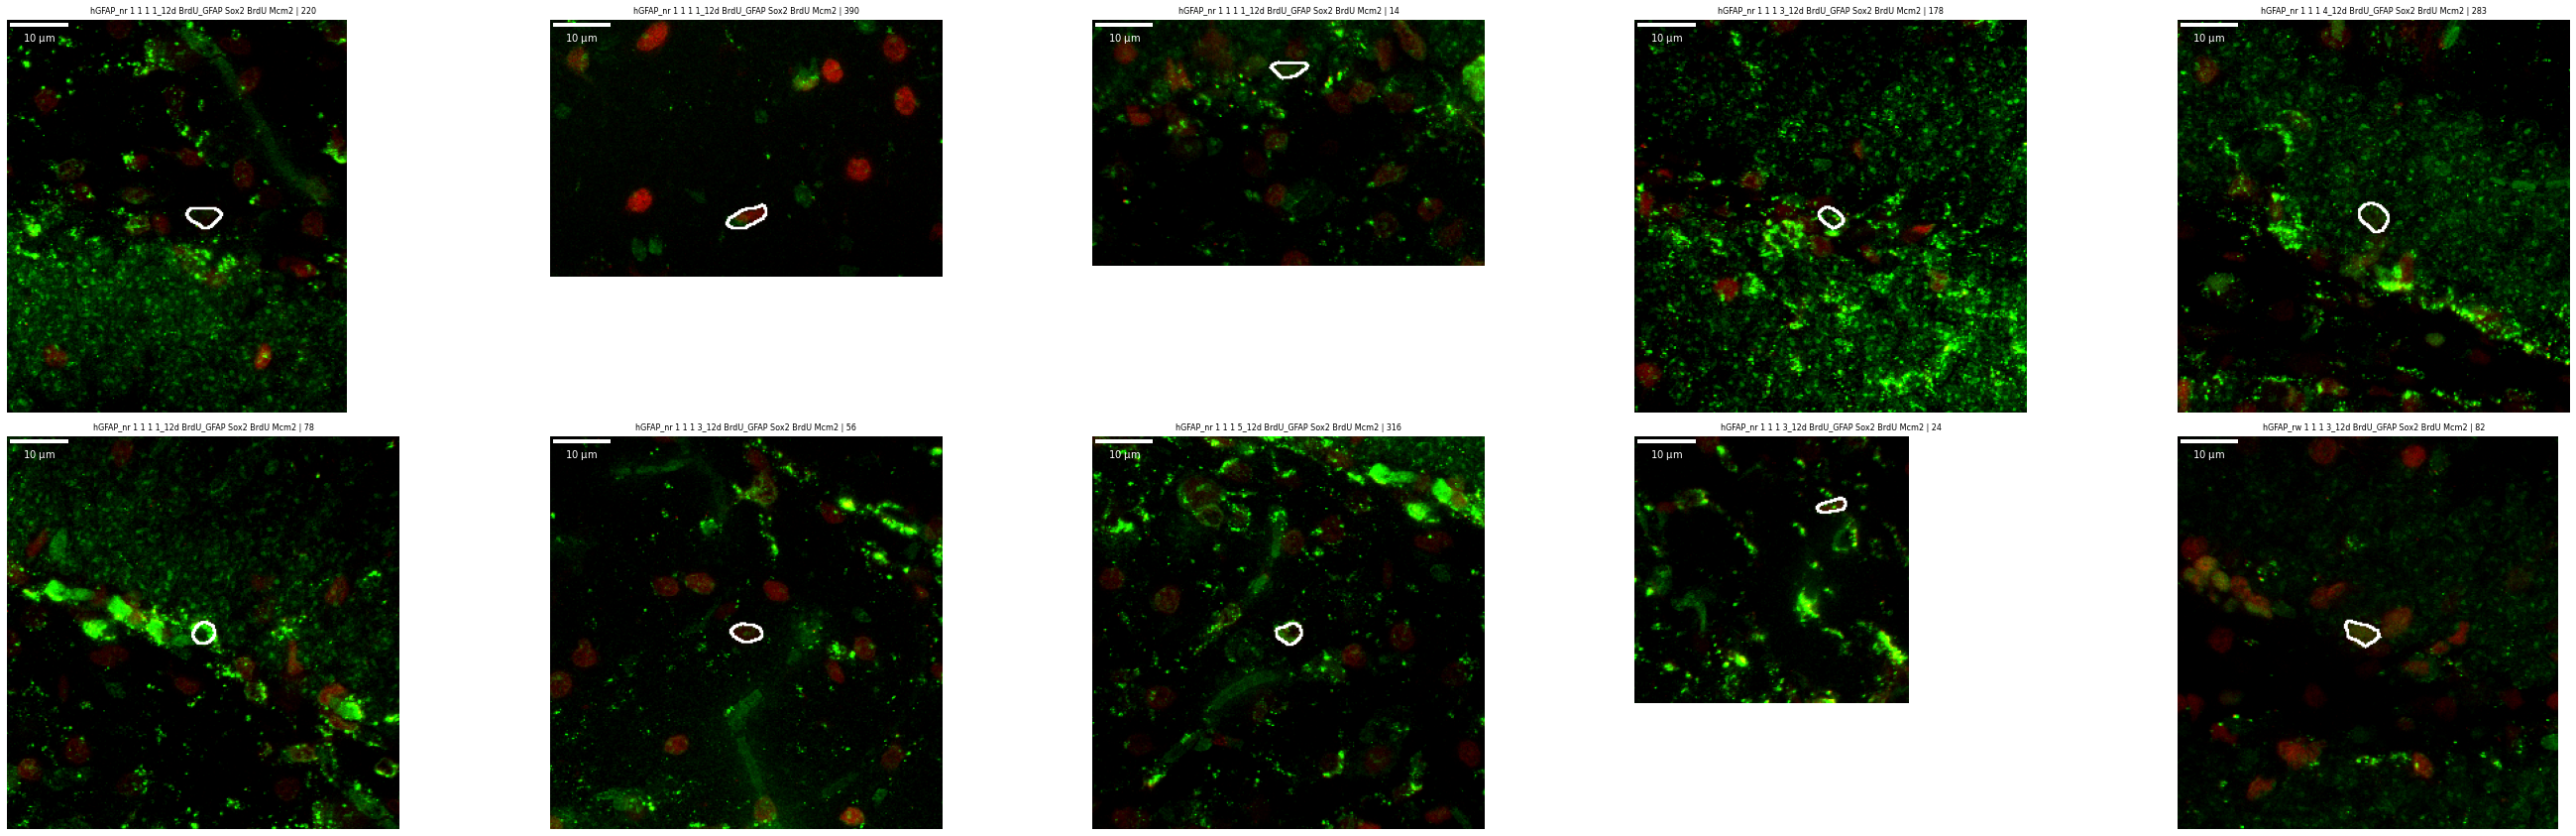

In [71]:
obj.showCells(n=10, ch2show = {'red': "Sox2", 'green': "Mcm2"}, 
              order_by = "avg_intensity_Sox2", ascending = True, 
             filter = None, show_nucleus = False)

In [26]:
obj.filterCells(cells = chosen_cells)

In [27]:
obj.count(["Sox2_group","Mcm2_group"])

Sox2_group  Mcm2_group
2           1             357
3           1             260
2           0             179
            2             168
3           2             112
            0              80
2           3              29
3           3              16
4           1              15
            2              12
            0               2
dtype: int64

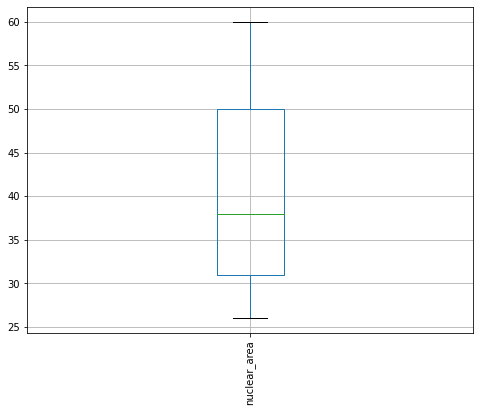

In [76]:
obj.plotVarDist(["nuclear_area"])


## Dimensional reduction and clustering

### Prepare matrix

Below are the nuclear features used for dimensional reduction

In [29]:
obj.showADataVars()


['avg_intensity_BrdU', 'nuclear_area', 'nuclear_perimeter', 'major_axis', 'minor_axis', 'axes_ratio', 'circularity', 'eccentricity', 'solidity', 'avg_intensity_core_BrdU', 'avg_intensity_internal_ring_BrdU', 'avg_intensity_external_ring_BrdU', 'total_intensity_core_BrdU', 'total_intensity_internal_ring_BrdU', 'total_intensity_external_ring_BrdU', 'total_intensity_BrdU', 'avg_intensity_Gfap', 'total_intensity_Gfap', 'avg_intensity_Sox2', 'total_intensity_Sox2', 'avg_intensity_Mcm2', 'total_intensity_Mcm2', 'Gfap_x_Sox2', 'Gfap_x_Mcm2', 'Sox2_x_Mcm2', 'Gfap_x_Sox2_x_Mcm2', 'dna_peaks', 'dna_dots', 'dna_dots_size_median', 'spatial_entropy']


In [31]:
exclude_feat = ['total_intensity_BrdU', 'Gfap_x_Sox2', 'Gfap_x_Mcm2', 'Sox2_x_Mcm2', 'Gfap_x_Sox2_x_Mcm2',
               'total_intensity_Gfap', 'total_intensity_Mcm2','total_intensity_Sox2', 'total_intensity_core_BrdU', 
                'total_intensity_internal_ring_BrdU', 'total_intensity_external_ring_BrdU']
obj.excludeVars(vars = exclude_feat)
obj.showADataVars()

['avg_intensity_BrdU', 'nuclear_area', 'nuclear_perimeter', 'major_axis', 'minor_axis', 'axes_ratio', 'circularity', 'eccentricity', 'solidity', 'avg_intensity_core_BrdU', 'avg_intensity_internal_ring_BrdU', 'avg_intensity_external_ring_BrdU', 'avg_intensity_Gfap', 'avg_intensity_Sox2', 'avg_intensity_Mcm2', 'dna_peaks', 'dna_dots', 'dna_dots_size_median', 'spatial_entropy']


In [32]:
## This graphic should be before

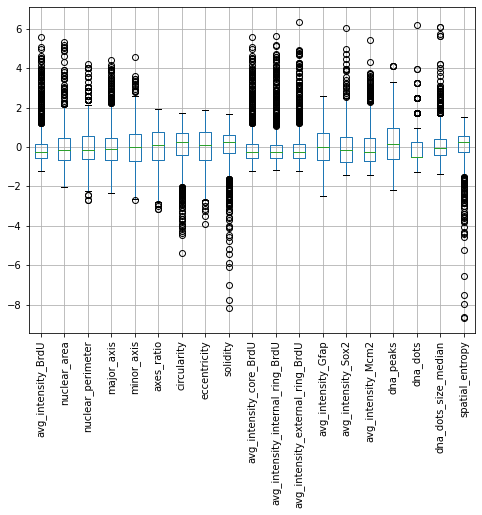

In [33]:
obj.plotVarDist(vars = "all", data_type="scaled")

In [37]:
# optional rescaling
obj.normAData(method = "maxabsscaler")

### Cluster and dim reduction

In [77]:
obj.findNeighbours(method = "umap")
obj.findClusters(method = "leiden", res=0.5)
obj.runDimReduc(method = "umap")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


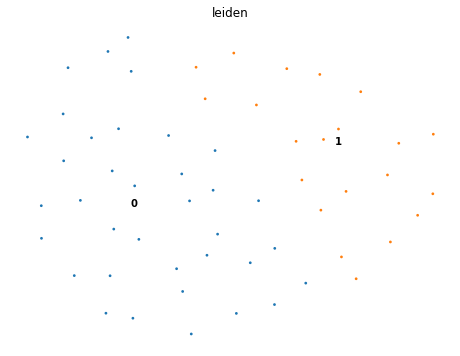

In [78]:
# Plot UMAP showing features
obj.plotDim(hue = "leiden", method="umap")

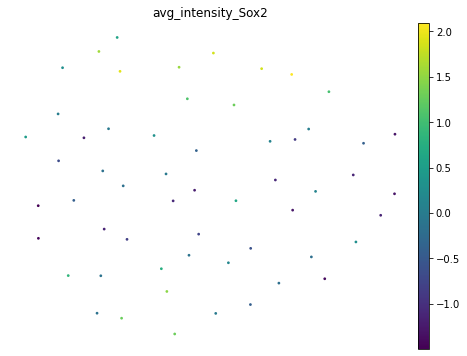

In [79]:
obj.plotDim(hue = "avg_intensity_Sox2", method="umap")

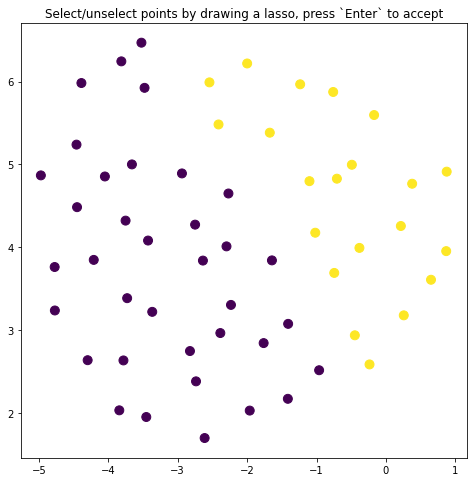

{'cells': ''}

In [83]:
obj.chooseCells(reduction = "umap", hue = "leiden")

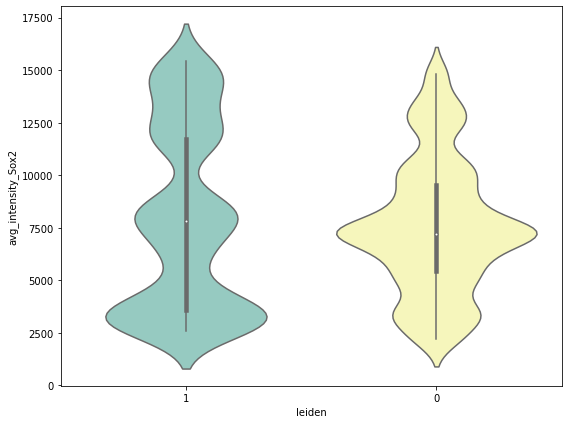

In [80]:
obj.plotData(x="leiden", y = "avg_intensity_Sox2", plot_type = "violin")

In [88]:
dat_vars = obj.data['norm'].copy()
dat_vars

,cellID,avg_intensity_BrdU,nuclear_area,nuclear_perimeter,major_axis,minor_axis,axes_ratio,circularity,eccentricity,solidity,...,dna_dots_size_median,spatial_entropy,Gfap_group,Sox2_group,Mcm2_group,experiment,path2ong,leiden,umap_1,umap_2
hGFAP_rw 1 1 1 1_12d BrdU_GFAP Sox2 BrdU Mcm2-87,87,20652,45,26,8.8,6.6,0.750,0.855,0.661,0.942,...,1.377,3.919,3,1,3,rw animal 1,/Users/m./Dropbox (CDN Team)/Tiff Images/Image...,1,-0.706277,4.828780
hGFAP_nr 1 1 1 3_12d BrdU_GFAP Sox2 BrdU Mcm2-241,241,12303,59,29,11.1,6.8,0.611,0.851,0.791,0.959,...,2.634,3.988,3,1,2,nonrw animal 1,/Users/m./Dropbox (CDN Team)/Tiff Images/Image...,1,0.215085,4.258279
hGFAP_nr 1 1 1 3_12d BrdU_GFAP Sox2 BrdU Mcm2-247,247,13830,60,30,10.8,7.2,0.662,0.863,0.750,0.958,...,1.796,3.994,3,0,2,nonrw animal 1,/Users/m./Dropbox (CDN Team)/Tiff Images/Image...,1,0.875264,4.913581
hGFAP_rw 1 1 1 2_12d BrdU_GFAP Sox2 BrdU Mcm2-76,76,29972,28,19,6.3,5.7,0.908,0.944,0.419,0.962,...,0.000,3.954,2,0,1,rw animal 1,/Users/m./Dropbox (CDN Team)/Tiff Images/Image...,0,-4.769076,3.239441
hGFAP_rw 1 1 1 3_12d BrdU_GFAP Sox2 BrdU Mcm2-125,125,28165,38,23,7.8,6.3,0.808,0.867,0.589,0.943,...,0.000,3.932,1,0,1,rw animal 1,/Users/m./Dropbox (CDN Team)/Tiff Images/Image...,0,-4.771810,3.763663
hGFAP_nr 1 1 1 3_12d BrdU_GFAP Sox2 BrdU Mcm2-402,402,41543,26,19,7.1,4.7,0.660,0.905,0.751,0.951,...,0.000,3.998,2,2,2,nonrw animal 1,/Users/m./Dropbox (CDN Team)/Tiff Images/Image...,0,-4.970633,4.868690
hGFAP_rw 1 1 1 2_12d BrdU_GFAP Sox2 BrdU Mcm2-84,84,24237,36,22,7.5,6.1,0.811,0.951,0.585,0.961,...,2.095,3.928,3,3,3,rw animal 1,/Users/m./Dropbox (CDN Team)/Tiff Images/Image...,1,-2.542192,5.990417
hGFAP_nr 1 1 1 1_12d BrdU_GFAP Sox2 BrdU Mcm2-390,390,18699,49,29,12.0,5.3,0.437,0.720,0.899,0.930,...,1.377,3.902,0,1,1,nonrw animal 1,/Users/m./Dropbox (CDN Team)/Tiff Images/Image...,0,-0.962252,2.518863
hGFAP_rw 1 1 1 1_12d BrdU_GFAP Sox2 BrdU Mcm2-126,126,17155,58,33,14.4,5.5,0.378,0.661,0.926,0.909,...,2.694,3.855,2,2,2,rw animal 1,/Users/m./Dropbox (CDN Team)/Tiff Images/Image...,1,-0.447879,2.940242
hGFAP_rw 1 1 1 2_12d BrdU_GFAP Sox2 BrdU Mcm2-106,106,26115,27,19,6.6,5.2,0.780,0.968,0.626,0.962,...,1.197,3.968,1,1,1,rw animal 1,/Users/m./Dropbox (CDN Team)/Tiff Images/Image...,0,-3.727763,3.387822


In [84]:
obj.showCells(RGB_contrasts=[4,3,4], n=5, ch2show={'red':'Sox2', 'green':'Mcm2'}, filter = "leiden == '0'")

KeyError: "['leiden', 'umap_1', 'umap_2'] not found in axis"

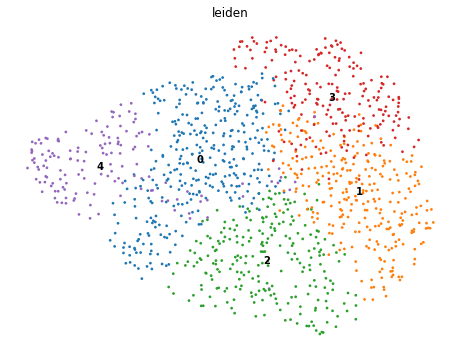

In [39]:
# Plot UMAP showing features
obj.plotDim(hue = "leiden", method="umap")

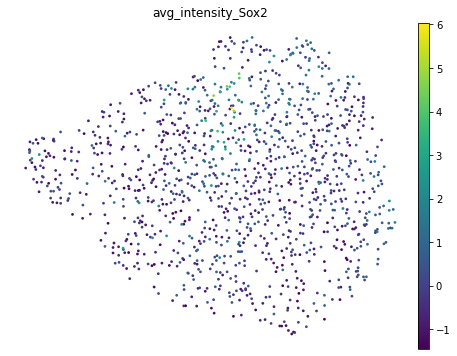

In [40]:
obj.plotDim(hue = "avg_intensity_Sox2", method="umap")

In [ ]:
obj.plotData(x="leiden", y = "avg_intensity_rfp", plot_type = "violin")

In [ ]:
obj.showCell(RGB_contrasts=[4,3,4], n=5, ch2show={'red':'rfp', 'green':'beta3'}, filter = "leiden == '0'")

In [91]:
clust1 = obj.filterCells(filter = "leiden == '1'", inplace=False)
clust1.plotData(x = "", y = "")

,cellID,avg_intensity_BrdU,nuclear_area,nuclear_perimeter,major_axis,minor_axis,axes_ratio,circularity,eccentricity,solidity,...,dna_dots_size_median,spatial_entropy,Gfap_group,Sox2_group,Mcm2_group,experiment,path2ong,leiden,umap_1,umap_2
hGFAP_rw 1 1 1 1_12d BrdU_GFAP Sox2 BrdU Mcm2-87,87,20652,45,26,8.8,6.6,0.750,0.855,0.661,0.942,...,1.377,3.919,3,1,3,rw animal 1,/Users/m./Dropbox (CDN Team)/Tiff Images/Image...,1,-0.706277,4.828780
hGFAP_nr 1 1 1 3_12d BrdU_GFAP Sox2 BrdU Mcm2-241,241,12303,59,29,11.1,6.8,0.611,0.851,0.791,0.959,...,2.634,3.988,3,1,2,nonrw animal 1,/Users/m./Dropbox (CDN Team)/Tiff Images/Image...,1,0.215085,4.258279
hGFAP_nr 1 1 1 3_12d BrdU_GFAP Sox2 BrdU Mcm2-247,247,13830,60,30,10.8,7.2,0.662,0.863,0.750,0.958,...,1.796,3.994,3,0,2,nonrw animal 1,/Users/m./Dropbox (CDN Team)/Tiff Images/Image...,1,0.875264,4.913581
hGFAP_rw 1 1 1 2_12d BrdU_GFAP Sox2 BrdU Mcm2-76,76,29972,28,19,6.3,5.7,0.908,0.944,0.419,0.962,...,0.000,3.954,2,0,1,rw animal 1,/Users/m./Dropbox (CDN Team)/Tiff Images/Image...,0,-4.769076,3.239441
hGFAP_rw 1 1 1 3_12d BrdU_GFAP Sox2 BrdU Mcm2-125,125,28165,38,23,7.8,6.3,0.808,0.867,0.589,0.943,...,0.000,3.932,1,0,1,rw animal 1,/Users/m./Dropbox (CDN Team)/Tiff Images/Image...,0,-4.771810,3.763663
hGFAP_nr 1 1 1 3_12d BrdU_GFAP Sox2 BrdU Mcm2-402,402,41543,26,19,7.1,4.7,0.660,0.905,0.751,0.951,...,0.000,3.998,2,2,2,nonrw animal 1,/Users/m./Dropbox (CDN Team)/Tiff Images/Image...,0,-4.970633,4.868690
hGFAP_rw 1 1 1 2_12d BrdU_GFAP Sox2 BrdU Mcm2-84,84,24237,36,22,7.5,6.1,0.811,0.951,0.585,0.961,...,2.095,3.928,3,3,3,rw animal 1,/Users/m./Dropbox (CDN Team)/Tiff Images/Image...,1,-2.542192,5.990417
hGFAP_nr 1 1 1 1_12d BrdU_GFAP Sox2 BrdU Mcm2-390,390,18699,49,29,12.0,5.3,0.437,0.720,0.899,0.930,...,1.377,3.902,0,1,1,nonrw animal 1,/Users/m./Dropbox (CDN Team)/Tiff Images/Image...,0,-0.962252,2.518863
hGFAP_rw 1 1 1 1_12d BrdU_GFAP Sox2 BrdU Mcm2-126,126,17155,58,33,14.4,5.5,0.378,0.661,0.926,0.909,...,2.694,3.855,2,2,2,rw animal 1,/Users/m./Dropbox (CDN Team)/Tiff Images/Image...,1,-0.447879,2.940242
hGFAP_rw 1 1 1 2_12d BrdU_GFAP Sox2 BrdU Mcm2-106,106,26115,27,19,6.6,5.2,0.780,0.968,0.626,0.962,...,1.197,3.968,1,1,1,rw animal 1,/Users/m./Dropbox (CDN Team)/Tiff Images/Image...,0,-3.727763,3.387822


#### DIFFMAP

In [41]:
obj.findNeighbours(method = "umap")
obj.findClusters(method = "leiden")
obj.runDimReduc(method = "diffmap")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9436016  0.9252641  0.91512764 0.85748863 0.84545034
     0.83518547 0.82236135 0.8160753  0.7799287  0.7764822  0.75710547
     0.7497346  0.7484511  0.7398939 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


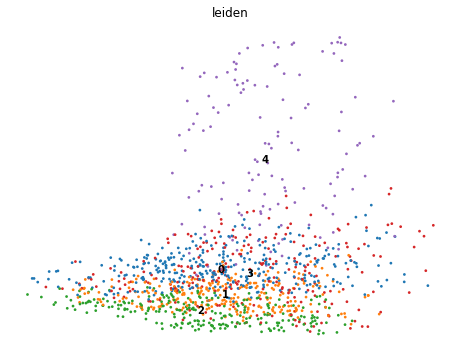

In [42]:
obj.plotDim(hue = "leiden", method="diffmap")

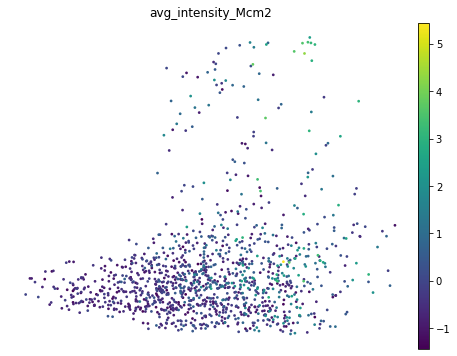

In [44]:
obj.plotDim(hue = "avg_intensity_Mcm2", method="diffmap")

#### Pseudotime
Choose a root cell for diffusion pseudotime:

In [45]:
%matplotlib tk
root_cells = obj.chooseCells(reduction = "diffmap")

In [46]:
%matplotlib inline

In [47]:
obj.runPT(root_cells = root_cells)

IndexError: list index out of range

In [ ]:
obj.plotDim(hue = "dpt_pseudotime", method="diffmap")

#### Stacked violin plot

In [46]:
fig, ax = plt.subplots(figsize = (5, 7))
sc.pl.stacked_violin(adata, data_cols, groupby = 'experiment', swap_axes = True, ax = ax, dendrogram = True)
fig.tight_layout()
plt.show()

NameError: name 'plt' is not defined

#### Pseudotime - heatmap

In [ ]:
# Enter order of clusters in pseudotime
pseudotime_path = [3,4,7]

In [47]:
# Heatmap - pseudotime
sc.pl.paga_path(
    adata, 
    pseudotime_path, 
    data_cols,
    show_node_names = True,
    n_avg = 50,
    annotations = ['dpt_pseudotime'],
    show_colorbar = True,
    color_map = 'coolwarm',
    groups_key = 'leiden',
    color_maps_annotations = {'dpt_pseudotime': 'viridis'},
    title = 'Path',
    return_data = False,
    normalize_to_zero_one = True,
    show = True
)

NameError: name 'sc' is not defined

### Save Object